In [20]:
import pandas as pd
import geopandas as gpd
import json
import numpy as np
import datetime
import plotly
import os
from plotly import graph_objects as go
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 50)
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 0})

%load_ext autoreload

from scripts.charts import plot_line, plot_bar, plot_peak, print_charts_country
from scripts.features import add_variables_covid, add_variables_apple, join_series_day_since, join_series_date

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [1940]:
df_original_reports = pd.read_csv("data-processed/rki-reports.csv")
df_apple = pd.read_csv("data-processed/data_apple_prepared.csv")
df_rki_orig = pd.read_csv('dash/data/data_rki_apple_prepared_dash.csv')
df_jh_world = pd.read_csv('dash/data/data_jhu_world.csv')
# df = pd.read_csv("dash/data/data_rki_apple_prepared_dash.csv")
df_rki_orig['date']=df_rki_orig['date'].astype('datetime64[ns]')
df_rki_orig.index = df_rki_orig.date
df_jh_world['date']=df_jh_world['date'].astype('datetime64[ns]')
df_jh_world.index = df_jh_world.date

In [737]:
# df_original_reports #.loc[df_original_reports.date != '2020-05-28'].drop("Unnamed: 0", axis=1).to_csv("data-processed/rki-reports.csv", index=False)

In [194]:
df_orig.columns

Index(['date_index', 'date', 'land', 'confirmed', 'dead', 'name', 'iso_code',
       'capital', 'area', 'population', 'confirmed_avg3', 'confirmed_change',
       'confirmed_change_avg3', 'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'population_100k', 'confirmed_per_100k', 'confirmed_change_per_100k',
       'confirmed_active_cases_per_100k',
       'confirmed_active_cases_change_per_100k', 'dead_avg3', 'dead_change',
       'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days

In [3]:
l = 'Bremen'
column = 'confirmed'
peak_index = df.loc[(df.land == l) & (df['confirmed_peak_date'] == -1), column].index.tolist()
df.loc[(df.index.isin(peak_index)) & (df.land == l), column]

date
2020-03-04      3
2020-04-19    585
Name: confirmed, dtype: int64

In [38]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler

def findpeak_trend(df):
    df_peak_log = df.loc[:, ['confirmed_peak_log']].dropna()
    
    days_pred_start = 10  # for how long to draw  the trend
    days_since_first_peak_start = 7  # how many days to wait since the first outbreak before estimating trend
    days_other_peak_starts = 7  # how many days since the second+ outbreak should pass before calculating trend

    # is we do not have enough data then exit
    if len(df_peak_log) < days_since_first_peak_start:
        df['peak_log_trend'] = np.NaN
        return df
    # find all indixes of outbreak beginnings
    peak_indixes = df.loc[df.confirmed_peak_date == -1].index.tolist()
    peak_indixes[0] = df_peak_log.index.min()
    
    # iterate over peak indixes
    for i, index in enumerate(peak_indixes):
        peak_index = peak_indixes[i]
        days_pred = days_pred_start
        if i == 0:
            # select y values since the beginning of the outbreak till defined number of days
            # and take a 3 days moving average for a smother trend
            days_add = days_since_first_peak_start
            
            # If we have two peak starts then the range we take to estmate the first should not be longer than the distance between 1st and 2nd
#             if len(peak_indixes) > 1:
#                 if days_add < len(df.loc[peak_index:peak_indixes[i+1]]):
#                     days_add = len(df.loc[peak_index:peak_indixes[i+1]])
#             else:
#                 # Else take all the days we have
#                 if days_add < len(df):
#                     days_add = len(df)
                    
            y = df_peak_log.loc[df_peak_log.index < peak_index +
                       datetime.timedelta(days=days_add), 'confirmed_peak_log'] #.rolling(3).median().dropna()
        else:
            # for the second+ outbreak use different number of minimum required days
            days_add = days_other_peak_starts
            # exis if we do not have enough data for an estimation
            if len(df.loc[peak_index:peak_index + datetime.timedelta(days=days_add)]) < days_other_peak_starts:
                return df
            else:
                # if we have more data to estimate second peak then use all of it
                days_other_peak_starts = len(df.loc[peak_index:df.index.max()])
                # if enough data then select y for estimating the trend
                y = df_peak_log.loc[(df_peak_log.index < df_peak_log.index.max()) &
                           (df_peak_log.index > peak_index), 'confirmed_peak_log'] #.rolling(3).median().dropna()

        # calculate X as number of days in Y and reshape to fit in LogReg model
        X = (y.index - y.index[0]).days.values.reshape(-1, 1)
    
        
        scaler = MinMaxScaler(feature_range=(0, 1))
        X = scaler.fit_transform(X)
        
        # train LogReg model
        reg = LinearRegression().fit(X, y)

        # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
        for days in [days_pred_start + i for i in [0, 10, 20, 35]]:
            X2 = (range(1, days + len(y)) + max(X)[0]).reshape(-1, 1)
            X2 = scaler.transform(X2)
            trend = reg.predict(X2)
            days_pred = days
            if min(trend) < 0:
                break
        
        

        # prepare y2 dataframe using index as a date range between the last date of y+1
        # and last date of y+days_estimated_for
        y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                                 y.index.max() + datetime.timedelta(days=days_pred))
        y2 = pd.DataFrame(index=y2_index, data=trend, columns=['peak_log_trend'])
        
        # remove extra negative values (if exist) except the first one (for clarity)
        try:
            first_negative_val = y2.loc[y2.peak_log_trend < 0].index[0]
            y2 = y2.loc[y2.index <= first_negative_val, 'peak_log_trend']
        except:
            pass
        # in case its the first peak simply merge DFs
        if i == 0:
            df = df.join(y2, how='outer')
        # otherwise merge and make sure that we fit all trends in the same column for easy plotting
        else:
            df = pd.merge(df, y2, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
            df['peak_log_trend'] = df.loc[:, ['peak_log_trend_x', 'peak_log_trend_y']].apply(
                lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
            df.drop(['peak_log_trend_x', 'peak_log_trend_y'], axis=1, inplace=True)

    return df

In [54]:
def add_trend_linear(df, column, date_range, days_add=15):
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    reg = LinearRegression().fit(X, y)

    # predict/estimate trend for 10, 20 and 30, 35 days forward, exit if the trend crosses 0
    X2 = (range(1, days_add + len(y)) + max(X)[0]).reshape(-1, 1)
    X2 = scaler.transform(X2)
    trend = reg.predict(X2)
    # prepare y2 dataframe using index as a date range between the last date of y+1
    # and last date of y+days_estimated_for
    y2_index = pd.date_range(y.index.min() + datetime.timedelta(days=1),
                             y.index.max() + datetime.timedelta(days=days_add))
    y2 = pd.DataFrame(index=y2_index, data=trend, columns=[f'{column}_trend'])
    df = df.join(y2, how='outer')
    return df

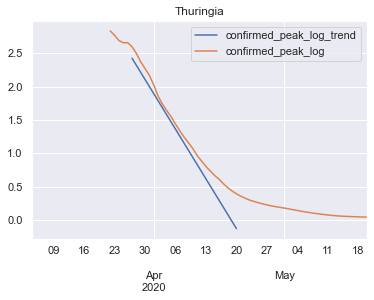

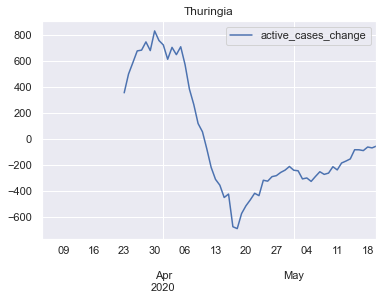

In [50]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_linear(df_ham, 'confirmed_peak_log', ['2020-03-20', '2020-04-05'])
dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
dd.loc[:, ['active_cases_change']].rolling(7).mean().plot(title=l)

In [48]:
df.land.unique()

array(['Baden-Wuerttemberg', 'Bavaria', 'Berlin', 'Brandenburg', 'Bremen',
       'Hamburg', 'Hesse', 'Lower Saxony',
       'Mecklenburg-Western Pomerania', 'North Rhine-Westphalia',
       'Rhineland-Palatinate', 'Saarland', 'Saxony', 'Saxony-Anhalt',
       'Schleswig-Holstein', 'Thuringia'], dtype=object)

In [195]:
# for l in df.land.unique():
#     df_ham = df.loc[df.land == l].copy()
#     df_ham.drop('peak_log_trend', axis=1, inplace=True)
#     dd = findpeak_trend(df_ham)
#     dd['active_cases_change'] = dd['confirmed_active_cases'] - dd['confirmed_active_cases'].shift(1)
#     dd.loc[:, ['peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)
#     dd.loc[:, ['active_cases_change', 'confirmed_change']].rolling(7).mean().plot(title=l)
#     dd.loc[:, ['confirmed_active_cases']].rolling(7).mean().plot(title=l)

In [196]:
# import matplotlib.pyplot as plt
# plt.close('all')

In [8]:
from fbprophet import Prophet
import datetime
import pandas as pd


def add_forecast_prophet(df_in, column, window=60, ):
    df = df_in.loc[:, [column]].dropna()
    df['ds'] = df.index
    df.columns = ['y', 'ds']
    m = Prophet(weekly_seasonality=False, daily_seasonality=False, yearly_seasonality=False)
    m.fit(df)
    future = m.make_future_dataframe(periods=window)
    forecast = m.predict(future)
    forecast.set_index(forecast.ds, inplace=True)
    forecast = forecast.loc[:, ['yhat', 'yhat_lower', 'yhat_upper']]
    df_extra_dates = pd.DataFrame(
        {'day': pd.Series([max(df_in.index) + datetime.timedelta(1), max(df_in.index) + datetime.timedelta(window)])})
    df_extra_dates.set_index('day', inplace=True)
    df_extra_dates = df_extra_dates.asfreq('D')
    df_in = df_in.append(df_extra_dates)
    df_result = pd.concat([df_in, forecast], axis=1)
    df_result[f'peak_log_trend'] = df_result.loc[df_result[column].isnull() == True, ['yhat']]

    return df_result


In [ ]:
# dd2 = add_forecast_prophet(df_ham, 'confirmed_peak_log')

In [ ]:
# dd2

In [ ]:
# dd2.loc[:, ['peak_log_trend', 'confirmed_peak_log']].plot()

In [116]:
import warnings
warnings.filterwarnings("ignore")
def add_trend_arima(df, column, date_range,  days_add=15, start=None):
    if start == None:
        start = df.index.max().date()
    y = df.loc[(df.index >= date_range[0]) & (df.index <= date_range[1]), column].dropna() #.rolling(3).median().dropna()

    # calculate X as number of days in Y and reshape to fit in LogReg model
    X = (y.index - y.index[0]).days.values.reshape(-1, 1)

    scaler = MinMaxScaler(feature_range=(0, 1))
    X = scaler.fit_transform(X)

    # train LogReg model
    import statsmodels.api as sm
    mod = sm.tsa.statespace.SARIMAX(y,
#                                     order=(0, 0, 0),
#                                     seasonal_order=(0,0,0,0),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

    results = mod.fit()
    
    pred_dynamic = results.get_prediction(start=pd.to_datetime(start), dynamic=True, full_results=True)
    pred_dynamic_ci = pred_dynamic.conf_int()
    y2 = pred_dynamic.predicted_mean
    y2.rename(f'{column}_trend', inplace=True)
    y2.columns = [f'{column}_trend']
    
    # Get forecast 500 steps ahead in future
    pred_uc = results.get_forecast(steps=days_add)
    pred_uc = pred_uc.predicted_mean
    pred_uc.rename(f'{column}_trend', inplace=True)
    pred_uc.columns = [f'{column}_trend']
    
#     print(y2,"\n")
#     print(pred_uc,"\n")
    
    print(results.summary().tables[1])
#     results.plot_diagnostics(figsize=(15, 12))
#     plt.show()

    df = df.join(y2, how='outer')
    df = pd.merge(df, pred_uc, left_index=True, right_index=True, how='outer', suffixes=('_x', '_y'))
    df[f'{column}_trend'] = df.loc[:, [f'{column}_trend_x', f'{column}_trend_y']].apply(
            lambda row: row[0] if pd.isnull(row[0]) == False else row[1], axis=1)
    df.drop([f'{column}_trend_x', f'{column}_trend_y'], axis=1, inplace=True)

    return df


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9633      0.017     55.800      0.000       0.929       0.997
sigma2         0.0214      0.011      1.939      0.052      -0.000       0.043


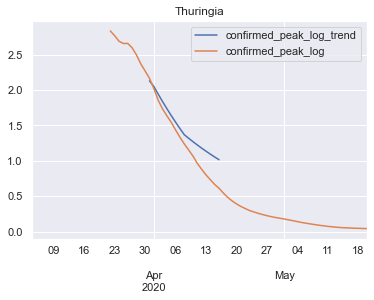

In [117]:
df_ham = df.loc[(df.land == 'Baden-Wuerttemberg')].copy()
df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, 'confirmed_peak_log', ['2020-03-04', '2020-04-01'], start='2020-03-25')
dd.loc[:, ['confirmed_peak_log_trend', 'confirmed_peak_log']].rolling(7).mean().plot(title=l)

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5376      0.103      5.233      0.000       0.336       0.739
sigma2      9343.6318    875.467     10.673      0.000    7627.747    1.11e+04


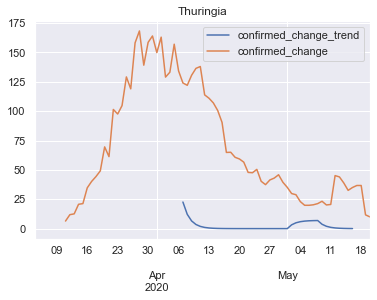

In [122]:
land = 'Hamburg'
column = 'confirmed_change'
df_ham = df.loc[(df.land == land)].copy()
# df_ham.drop('peak_log_trend', axis=1, inplace=True)
dd = add_trend_arima(df_ham, column, ['2020-03-04', '2020-05-01'], start='2020-04-01')
dd.loc[:, [f'{column}_trend', column]].rolling(7).mean().plot(title=l)

In [162]:
df_jh_world.columns

Index(['state', 'land', 'lat', 'lng', 'iso_code', 'date', 'confirmed',
       'confirmed_avg3', 'confirmed_change', 'confirmed_change_avg3',
       'confirmed_change_3w', 'confirmed_change_pct',
       'confirmed_change_pct_avg3', 'confirmed_change_pct_3w',
       'confirmed_doubling_days', 'confirmed_doubling_days_3w',
       'confirmed_doubling_days_avg3', 'confirmed_doubling_days_3w_avg3',
       'confirmed_active_cases', 'confirmed_active_cases_change',
       'confirmed_peak_log', 'confirmed_peak_date', 'confirmed_day_since_10',
       'population_100k', 'confirmed_per_100k', 'confirmed_change_per_100k',
       'confirmed_active_cases_per_100k',
       'confirmed_active_cases_change_per_100k', 'dead', 'dead_avg3',
       'dead_change', 'dead_change_avg3', 'dead_change_3w', 'dead_change_pct',
       'dead_change_pct_avg3', 'dead_change_pct_3w', 'dead_doubling_days',
       'dead_doubling_days_3w', 'dead_doubling_days_avg3',
       'dead_doubling_days_3w_avg3', 'dead_day_since_10', 

In [161]:
# sorted(df_jh_world.round(3)['confirmed_change_per_100k'], reverse=True)

In [143]:
df_rki_orig['date'] = df_rki_orig['date'].astype('datetime64[ns]')

In [141]:
selected_colum = 'confirmed'

ro = df_rki_orig.groupby('land').rolling(7, on='date').mean().reset_index(drop=False).loc[:,
         ['date', 'land', selected_colum]]
df = df_rki_orig.merge(ro, on=['date', 'land'], suffixes=('', '_weekly')).round(3)

In [200]:
df_apple.head(1)

,date_index,geo_type,region,alternative_name,sub-region,country,date,driving,transit,walking
0,2020-01-13,city,Aachen,NaN,North Rhine-Westphalia,Germany,2020-01-13,100.0,NaN,100.0


In [201]:
df_jh_world.head(1)

,land,iso_code,date,confirmed,confirmed_change,confirmed_change_pct_3w,confirmed_doubling_days_3w_avg3,confirmed_active_cases,confirmed_active_cases_change,confirmed_peak_date,population_100k,confirmed_per_100k,confirmed_change_per_100k,confirmed_active_cases_per_100k,dead,dead_change,dead_doubling_days,lethality,dead_per_100k,dead_change_per_100k,region_wb
date,,,,,,,,,,,,,,,,,,,,,
2020-02-24,Afghanistan,AFG,2020-02-24,1.0,NaN,NaN,NaN,NaN,NaN,-1,371.72,0.00269,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,South Asia


In [888]:
import plotly.graph_objects as go
from datetime import timedelta
from plotly.subplots import make_subplots
def add_gauge(fig, region, current_value, yd_value, position):

    fig.add_trace(go.Indicator(
        mode="number+delta",
        delta={'reference': yd_value},
        value=current_value,
        #         domain = {'x': [0, 1], 'y': [0.2, 0.9]},
        title={'text': f"{region}", 'font': dict(size=14)}),
        row=position[0], col=position[1]
    )
    return fig


def plot_gauges(df, value_column, aggregate_by_column='region_wb'):

    LAYOUT_MAX_CHARTS = 9

    plots = [{"type": 'indicator'} for i in range(LAYOUT_MAX_CHARTS)]
    fig = make_subplots(rows=1, cols=9,
                        specs=[plots[0:]],
#                         vertical_spacing=0.15,
                        horizontal_spacing=0.01,
#                         column_widths=[2, 0.5, 0.5, 0.85, 0.5, 0.5, 0.5, 0.5, 0.5],
#                         row_heights=[0.1],
                        )
    
    # Aggregate most recent day's value for regions
    current_reg_df_sum = df.loc[df.date == df.date.max(), :].groupby(aggregate_by_column).agg(['sum'])[value_column]
    # Aggregate yesterday's value for regions
    yd_reg_df_sum = df.loc[df.date == df.date.max() - timedelta(days=1), :].groupby(aggregate_by_column).agg(['sum'])[value_column]

    # Sort values to sort charts below
    current_reg_df_sum = current_reg_df_sum.sort_values(by='sum', ascending=False)

    aggregated_categories = current_reg_df_sum.index.unique()
    display_values = min([len(aggregated_categories), LAYOUT_MAX_CHARTS])
    
    fig = add_gauge(fig, 'World', current_reg_df_sum.sum()['sum'], yd_reg_df_sum.sum()['sum'], [1,1])

    for i, region in enumerate(aggregated_categories[:display_values]):

        current_value = current_reg_df_sum.reset_index().loc[current_reg_df_sum.index == region, 'sum'].round(3).values[0]
        yd_value = yd_reg_df_sum.reset_index().loc[yd_reg_df_sum.index == region, 'sum'].round(3).values[0]

        position = [1, i + 2]
        
        fig = add_gauge(fig, region, current_value, yd_value, position)

    fig.update_layout(paper_bgcolor='#1f2630',
                      font={'color': "rgb(204, 204, 204)", 'family': "Garamond"},
                      margin=dict(
                          autoexpand=True,
                          l=0,
                          r=0,
                          t=50,
                          b=10,
                      ),
                      height=120,
                      width=1600
                      )

    return fig

In [955]:
%%timeit
plot_gauges(df_jh_world, 'confirmed', aggregate_by_column='region_wb')

432 ms ± 141 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [956]:
%%timeit
plot_gauges_ve(ve_jh_world, 'confirmed', aggregate_by_column='region_wb')

596 ms ± 15.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [739]:
%%time
df_jh_world.loc[df_jh_world.index == df_jh_world.index.max(), :].groupby(by=['land', 'region_wb']).agg(['max'])['population_100k'].groupby('region_wb').agg('sum') #.sort_values(by='sum',ascending=False).round(0)

CPU times: user 204 ms, sys: 10.3 ms, total: 214 ms
Wall time: 411 ms


,max
region_wb,
East Asia & Pacific,22766.00
Europe & Central Asia,4095.64
European Union,5026.52
Latin America & Caribbean,6375.80
Middle East & North Africa,4484.29
North America,3637.46
South Asia,18143.88
Sub-Saharan Africa,10748.51


In [740]:
import vaex as ve

In [745]:
%%time
df_jh_world = pd.read_csv('dash/data/data_jhu_world.csv')

CPU times: user 48.8 ms, sys: 13 ms, total: 61.8 ms
Wall time: 69.3 ms


In [746]:
%%time
ve_jh_world = ve.open('dash/data/data_jhu_world.csv')

CPU times: user 70.2 ms, sys: 16.1 ms, total: 86.3 ms
Wall time: 95.8 ms


In [758]:
%%time
df_jh_world.groupby(by=['land']).agg(['sum'])['confirmed_change']

CPU times: user 193 ms, sys: 4.9 ms, total: 198 ms
Wall time: 256 ms


,sum
land,
Afghanistan,13035.0
Albania,1074.0
Algeria,8996.0
Andorra,762.0
Angola,73.0
...,...
Vietnam,325.0
West Bank and Gaza,442.0
Yemen,277.0


In [759]:
%%time
ve_jh_world['land', 'confirmed_change'].groupby(by='land', agg={'confirmed_change': 'sum'})

CPU times: user 24.2 ms, sys: 3.43 ms, total: 27.7 ms
Wall time: 26.6 ms


#,land,confirmed_change
0,Afghanistan,13035.0
1,Albania,1074.0
2,Algeria,8996.0
3,Andorra,762.0
4,Angola,73.0
...,...,...
181,Vietnam,325.0
182,West Bank and Gaza,442.0
183,Yemen,277.0
184,Zambia,1055.0


In [767]:
df = df_jh_world
aggregate_by_column = 'region_wb'
value_column = 'confirmed_change'

In [855]:
%%time
df = df_jh_world
# Aggregate most recent day's value for regions
current_reg_df_sum = df.loc[df.date == df.date.max(), :].groupby(aggregate_by_column).agg(['sum'])[value_column]
current_reg_df_sum

CPU times: user 99.9 ms, sys: 5.04 ms, total: 105 ms
Wall time: 140 ms


,sum
region_wb,
East Asia & Pacific,1653.0
Europe & Central Asia,12517.0
European Union,10244.0
Latin America & Caribbean,43411.0
Middle East & North Africa,10273.0
North America,23564.0
South Asia,12261.0
Sub-Saharan Africa,3170.0


In [875]:
%%time
df = ve_jh_world
# df['date'] = df['date'].astype('datetime64')
# Aggregate most recent day's value for regions
current_reg_df_sum = df[df.date == np.datetime64(df.date.max())].groupby(aggregate_by_column, agg={'confirmed_change': 'sum'}) #.sort(by='confirmed_change', ascending=False)
current_reg_df_sum


CPU times: user 61.6 ms, sys: 5.15 ms, total: 66.8 ms
Wall time: 88.2 ms


#,region_wb,confirmed_change
0,South Asia,12261
1,Europe & Central Asia,12517
2,Middle East & North Africa,10273
3,Sub-Saharan Africa,3170
4,Latin America & Caribbean,43411
5,East Asia & Pacific,1653
6,European Union,10244
7,North America,23564


In [868]:
df_jh_world['date'] = df_jh_world['date'].astype('datetime64')

In [873]:
%%time
# Aggregate yesterday's value for regions
# df = df_jh_world
# yd_reg_df_sum = df.loc[df.date == df.date.max() - timedelta(days=1), :].groupby(aggregate_by_column).agg(['sum'])[value_column]

df = ve_jh_world
yd_reg_df_sum = df[df.date == np.datetime64(df.date.max()) - np.timedelta64(1,'D') ].groupby(aggregate_by_column, agg={'confirmed_change': 'sum'}) #.sort(by='confirmed_change', ascending=False)
yd_reg_df_sum

CPU times: user 45.6 ms, sys: 4.12 ms, total: 49.7 ms
Wall time: 51.9 ms


#,region_wb,confirmed_change
0,South Asia,11189
1,Europe & Central Asia,12179
2,Middle East & North Africa,9494
3,Sub-Saharan Africa,3934
4,Latin America & Caribbean,39213
5,East Asia & Pacific,1751
6,European Union,5200
7,North America,19162


In [ ]:
# Sort values to sort charts below
current_reg_df_sum = current_reg_df_sum.sort_values(by='sum', ascending=False)
current_reg_df_sum

In [946]:
import plotly.graph_objects as go
from datetime import timedelta
from plotly.subplots import make_subplots
def add_gauge(fig, region, current_value, yd_value, position):

    fig.add_trace(go.Indicator(
        mode="number+delta",
        delta={'reference': yd_value},
        value=current_value,
        #         domain = {'x': [0, 1], 'y': [0.2, 0.9]},
        title={'text': f"{region}", 'font': dict(size=14)}),
        row=position[0], col=position[1]
    )
    return fig


def plot_gauges_ve(df, value_column, aggregate_by_column='region_wb'):

    LAYOUT_MAX_CHARTS = 9

    plots = [{"type": 'indicator'} for i in range(LAYOUT_MAX_CHARTS)]
    fig = make_subplots(rows=1, cols=9,
                        specs=[plots[0:]],
#                         vertical_spacing=0.15,
                        horizontal_spacing=0.01,
#                         column_widths=[2, 0.5, 0.5, 0.85, 0.5, 0.5, 0.5, 0.5, 0.5],
#                         row_heights=[0.1],
                        )
    
    # Aggregate most recent day's value for regions
#     current_reg_df_sum = df.loc[df.date == df.date.max(), :].groupby(aggregate_by_column).agg(['sum'])[value_column]
    current_reg_df_sum = df[df.date == np.datetime64(df.date.max())].groupby(aggregate_by_column, agg={value_column: 'sum'}).sort(by=value_column, ascending=False)

    # Aggregate yesterday's value for regions
#     yd_reg_df_sum = df.loc[df.date == df.date.max() - timedelta(days=1), :].groupby(aggregate_by_column).agg(['sum'])[value_column]
    yd_reg_df_sum = df[df.date == np.datetime64(df.date.max()) - np.timedelta64(1,'D') ].groupby(aggregate_by_column, agg={value_column: 'sum'}) #.sort(by='confirmed_change', ascending=False)

    # Sort values to sort charts below
#     current_reg_df_sum = current_reg_df_sum.sort_values(by='sum', ascending=False)

    aggregated_categories = current_reg_df_sum.region_wb
    display_values = min([aggregated_categories.count(), LAYOUT_MAX_CHARTS])
    
    fig = add_gauge(fig, 'World', current_reg_df_sum.sum(value_column).item(0), yd_reg_df_sum.sum(value_column).item(0), [1,1])

    for i, region in enumerate(aggregated_categories.tolist()[:display_values]):

        current_value = current_reg_df_sum[current_reg_df_sum.region_wb == region][value_column].tolist()[0]
        yd_value = yd_reg_df_sum[yd_reg_df_sum.region_wb == region][value_column].tolist()[0]
#         yd_value = yd_reg_df_sum.reset_index().loc[yd_reg_df_sum.index == region, 'sum'].round(3).values[0]

        position = [1, i + 2]
        
        fig = add_gauge(fig, region, current_value, yd_value, position)

    fig.update_layout(paper_bgcolor='#1f2630',
                      font={'color': "rgb(204, 204, 204)", 'family': "Garamond"},
                      margin=dict(
                          autoexpand=True,
                          l=0,
                          r=0,
                          t=50,
                          b=10,
                      ),
                      height=120,
                      width=1600
                      )

    return fig

CPU times: user 659 ms, sys: 32.6 ms, total: 692 ms
Wall time: 762 ms


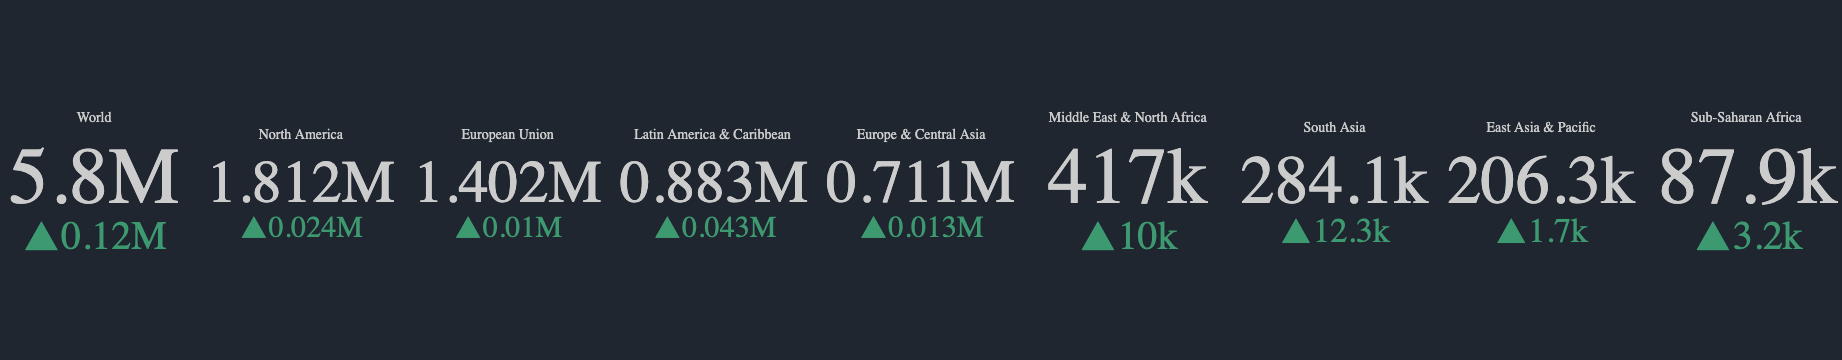

In [947]:
%%time
plot_gauges_ve(ve_jh_world, 'confirmed', aggregate_by_column='region_wb')

In [945]:
df = ve_jh_world
value_column = 'confirmed'
aggregate_by_column= 'region_wb'
current_reg_df_sum = df[df.date == np.datetime64(df.date.max())].groupby(aggregate_by_column, agg={value_column: 'sum'}).sort(by=value_column, ascending=False)
# current_reg_df_sum[current_reg_df_sum.region_wb == 'European Union']['confirmed_change']
d = current_reg_df_sum[current_reg_df_sum.region_wb == region][value_column]
d.tolist()[0]

882832.0

In [931]:
aggregated_categories.tolist()

['North America',
 'European Union',
 'Latin America & Caribbean ',
 'Europe & Central Asia',
 'Middle East & North Africa',
 'South Asia',
 'East Asia & Pacific',
 'Sub-Saharan Africa ']

In [1026]:
import pyarrow as pa
import redis
redis_conf = {'host': 'localhost', "port": 6379, 'db': 0}

redis_pool = None

def init():
    global redis_pool
    print("PID %d: initializing redis pool..." % os.getpid())
    redis_pool = redis.ConnectionPool(host=redis_conf['host'], port=redis_conf['port'], db=redis_conf['db'])

def cache_df(alias,df):

    cur = redis.Redis(connection_pool=redis_pool)
    context = pa.default_serialization_context()
    df_compressed =  context.serialize(df).to_buffer().to_pybytes()

    res = cur.set(alias,df_compressed)
    if res == True:
        print('df cached')

# def cache_df(alias,df):

#     pool = redis.ConnectionPool(host=redis_conf['host'], port=redis_conf['port'], db=redis_conf['db'])
#     cur = redis.Redis(connection_pool=pool)
#     context = pa.default_serialization_context()
#     df_compressed =  context.serialize(df).to_buffer().to_pybytes()

#     res = cur.set(alias,df_compressed)
#     if res == True:
#         print('df cached')

In [1027]:
init()

PID 4931: initializing redis pool...


In [1028]:
cache_df('df_test', df_jh_world)

df cached


In [1042]:
def get_cached_df(alias):

    cur = redis.Redis(connection_pool=redis_pool)
    context = pa.default_serialization_context()
    all_keys = [key.decode("utf-8") for key in cur.keys()]

    if alias in all_keys:   
        result = cur.get(alias)

        dataframe = pd.DataFrame.from_dict(context.deserialize(result))

        return dataframe

    return None

# def get_cached_df(alias):

#     pool = redis.ConnectionPool(redis_conf['host'], port=redis_conf['port'], db=redis_conf['db']) 
#     cur = redis.Redis(connection_pool=pool)
#     context = pa.default_serialization_context()
#     all_keys = [key.decode("utf-8") for key in cur.keys()]

#     if alias in all_keys:   
#         result = cur.get(alias)

#         dataframe = pd.DataFrame.from_dict(context.deserialize(result))

#         return dataframe

#     return None

In [1036]:
# pool = redis.ConnectionPool(redis_conf['host'], port=redis_conf['port'], db=redis_conf['db']) 
# cur = redis.Redis(connection_pool=pool)

In [1037]:
# cl = redis.Redis(redis_conf['host'], port=redis_conf['port'], db=redis_conf['db'])
# cl.set('hello', 'world')

In [1038]:
# cl.get('hello')

In [1204]:
df = get_cached_df('df_test')

In [1935]:
import plotly.graph_objects as go
import scipy as sp

def get_digit(s, place):
    s = "".join([i for i in str(s) if i.isdigit()]).lstrip("0")
    if len(s) >= place:
        return s[place - 1]
    else:
        return -1
    
def bar(df, column , digit, df_benford, land):
    d1 = df.loc[df[f'{digit}digit'] != -1, :]
    obs = len(d1)
    
    d1_c = d1.groupby(by=f'{digit}digit').count().loc[:, [column]]
    d1_c.columns = ['cnt']
    d1 = (d1.groupby(by=f'{digit}digit').count() / d1[f'{digit}digit'].count() * 100).loc[:, [column]].round(1)
    d1 = d1.join(df_benford, how='outer')
    d1 = d1.join(d1_c, how='outer')

    d1[f'ben{digit}'] = d1[f'ben{digit}']/100
    d1[column] = d1[column]/100

    def std(row):
        return (row[f'ben{digit}'] * (1 - row[f'ben{digit}']) / row.cnt)**0.5

    def zscore(row):
        return abs((abs(row[column] - row[f'ben{digit}']) - (1 / row.cnt * 2)) / row.s)

    d1['s'] = d1.apply(lambda r: std(r), axis=1)
    d1['z'] = d1.apply(lambda r: zscore(r), axis=1)

    d1['p'] = np.round(sp.stats.norm.pdf(np.abs(d1['z'])),2)
    
    from plotly.subplots import make_subplots

    # Create figure with secondary y-axis
    fig = make_subplots(specs=[[{"secondary_y": True}]])
#     fig = go.Figure()
    fig.add_trace(go.Scatter(
        mode='lines',
        line=dict(
             color='DarkBlue',
             width=5
         ),
        x=d1.index,
        y=d1[column],
        name=f'{digit} place digit',
        marker_color='DarkBlue'))
    
    fig.add_trace(go.Scatter(
        mode='lines',
        line=dict(
             color='white',
             width=5,
             dash='dot', 
         ),
        x=d1.index,
        y=d1[f'ben{digit}'],
        name='Benford',
        marker_color='white'))
    
#     fig.add_trace(go.Indicator(
#         mode='number',
#         title='Correlation',
#         value=d1.loc[:, [column, f'ben{digit}']].corr().iloc[0,1].round(2)*100))

    fig.add_shape(
            # Line Diagonal
                type="line",
                x0=0,
                y0=0.05,
                x1=9,
                y1=0.05,
                line=dict(
                    color="DarkGrey",
                    width=1.5,
                    dash="dash",
                ), 
                yref="y2"
    )
    
    fig.add_trace(go.Bar(
        x=d1.index,
        y=d1['p'],
        width=[0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1,0.1],
        name=f'p-value',
        marker=dict(color='DarkGrey',
#                      opacity=0.8
#                         line=dict(width=1)
                     ),
        ),secondary_y=True)
    
    fig.update_layout(
        margin=dict(l=0, r=0, t=35, b=0),
        autosize=False,
        width=800,
        height=250, 
        paper_bgcolor="LightGray", 
        plot_bgcolor='LightGray',  # '#1f2630'
        title=f"{land}: {' '.join([x.capitalize() for x in column.split('_')])}, digit position {digit}",
#         barmode='group',
#         xaxis_title= f"{' '.join([x.capitalize() for x in column.split('_')])}, digit position {digit}",
        yaxis_title='Frequency',
        xaxis_title='Number',
        yaxis2_title='p-value',
        xaxis=dict(
            linecolor='LightSteelBlue',
            showgrid=False,
            dtick=1), 
        yaxis=dict(showgrid=False,),
        font=dict(color='DarkBlue'), # '#2cfec1'
        yaxis2=dict(showgrid=False, range=[0, 0.2]))
    
#     print('Observations: ', obs)
#     print("Correlation: ", f"{d1.loc[:, [column, f'ben{digit}']].corr().iloc[0,1].round(2)*100}%")
    fig.show()
    
def plot_benford(df, land, column = 'dead_change'):
    df2 = df.loc[(df.land == land) & (df[column] > 0), [column]].dropna().astype(int)
    
    ben1 = pd.DataFrame(data=[30.1 ,17.6 ,12.5	,9.7 ,7.9 ,6.7 ,5.8	,5.1 ,4.6], index = [str(x) for x in range(1,10)], columns=['ben1'])
    ben2 = pd.DataFrame(data=[12.0,	11.4, 10.9,	10.4, 10.0,	9.7, 9.3, 9.0, 8.8, 8.5], index = [str(x) for x in range(0,10)], columns=['ben2'])

    df2['1digit'] = df2[column].apply(lambda x: get_digit(x, 1)) 
    df2['2digit'] = df2[column].apply(lambda x: get_digit(x, 2)) 

    bar(df2, column, 1, ben1, land)

    bar(df2, column, 2, ben2, land)


In [1943]:
df_jh_world.loc[df_jh_world.land == 'Germany', 'dead_change'].mean()

104.96296296296296

In [1944]:
df_jh_world.loc[df_jh_world.land == 'Germany', 'dead_change'].median()

78.0

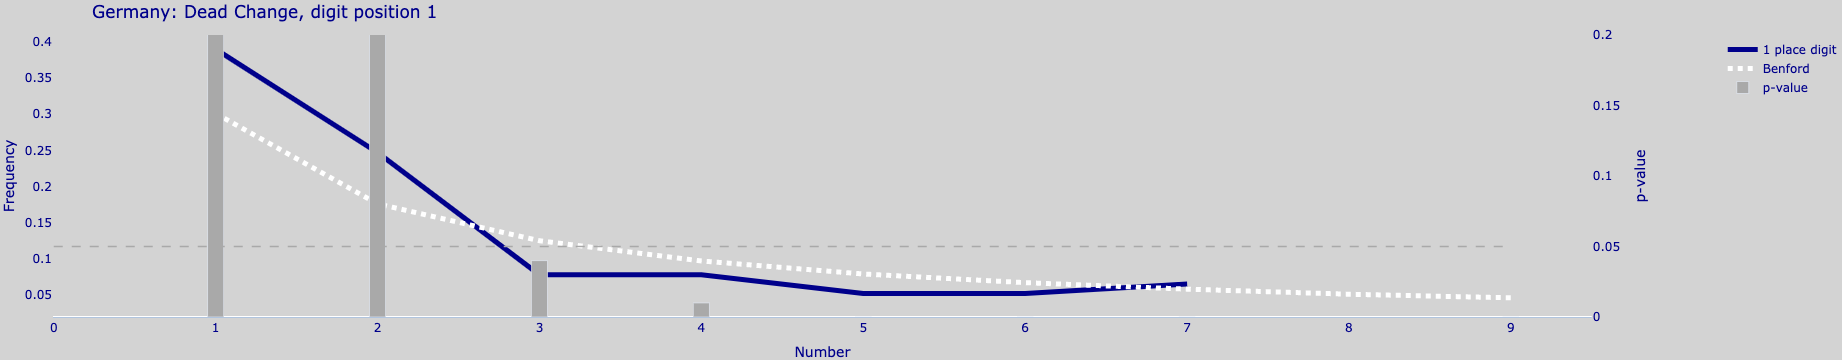

In [1941]:
plot_benford(df_jh_world, "Germany", 'dead_change')

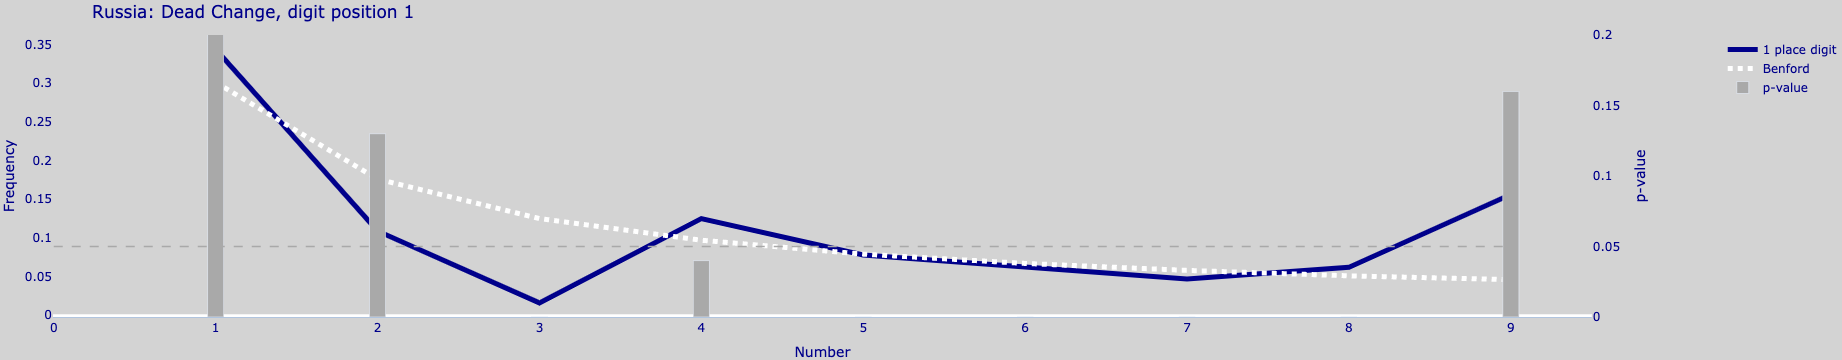

In [1942]:
plot_benford(df_jh_world, "Russia", 'dead_change')

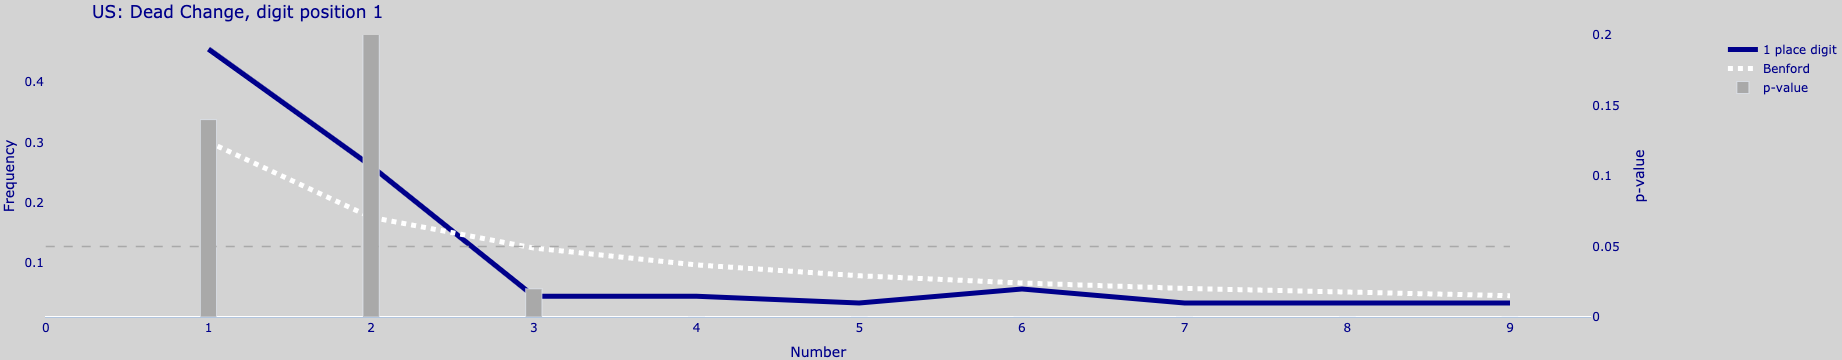

In [1938]:
plot_benford(df, "US", 'dead_change')

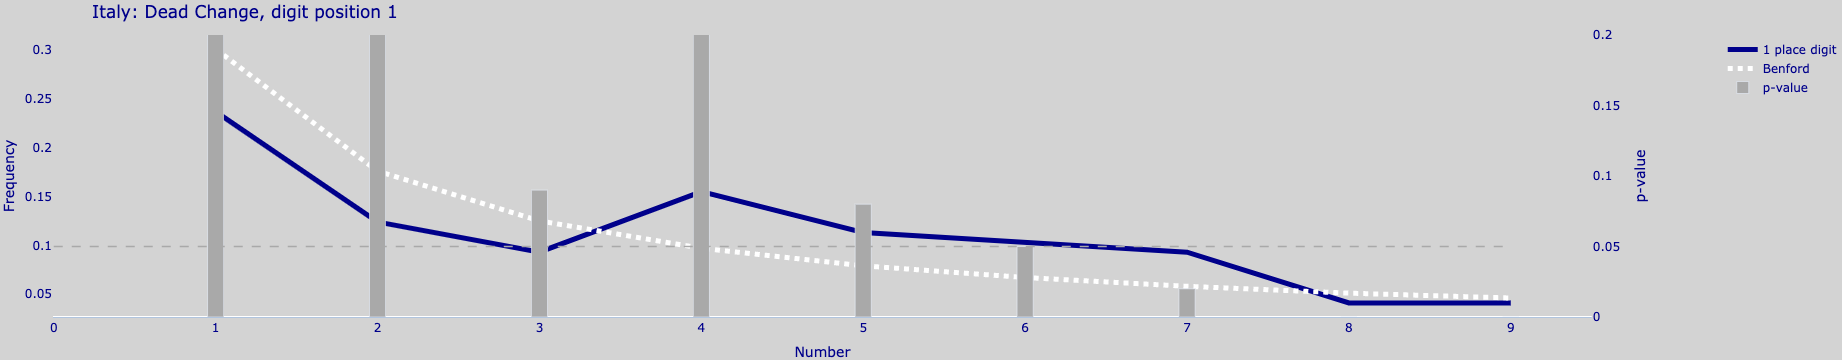

In [1939]:
plot_benford(df, "Italy", 'dead_change')

In [1889]:
import scipy as sp

In [1811]:
digit = 1
land = 'Germany'
column = 'dead_change'
df2 = df_jh_world.loc[(df_jh_world.land == land) & (df_jh_world[column] > 0), [column]].dropna().astype(int)
    
get_digit = pd.DataFrame(data=[30.1	,17.6	,12.5	,9.7	,7.9	,6.7	,5.8	,5.1	,4.6], index = [str(x) for x in range(1,10)], columns=['ben1'])
ben2 = pd.DataFrame(data=[12.0,	11.4,	10.9,	10.4,	10.0,	9.7,	9.3,	9.0,	8.8,	8.5], index = [str(x) for x in range(0,10)], columns=['ben2'])

def get_digit(s, place):
    s = [i for i in str(s) if i.isdigit()]
    if len(s) >= place:
        return s[place - 1]
    else:
        return -1
    
df2['1digit'] = df2[column].apply(lambda x: get_digit(x, 1)) 
df2['2digit'] = df2[column].apply(lambda x: get_digit(x, 2)) 
d1 = df2.loc[df2[f'{digit}digit'] != -1, :]
obs = len(d1)

d1_c = d1.groupby(by=f'{digit}digit').count().loc[:, [column]]
d1_c.columns = ['cnt']
d1 = (d1.groupby(by=f'{digit}digit').count() / d1[f'{digit}digit'].count() * 100).loc[:, [column]].round(1)
d1 = d1.join(ben1, how='outer')
d1 = d1.join(d1_c, how='outer')

d1[f'ben{digit}'] = d1[f'ben{digit}']/100
d1[column] = d1[column]/100
# d1.loc[d1.index == '9', column] = .15
# d1.loc[d1.index == '9', 'cnt'] = 100

# d1[column] = d1['ben1']
# d1['cnt'] = (d1['ben1'] * 1000).astype(int)

def std(row):
    return (row[f'ben{digit}'] * (1 - row[f'ben{digit}']) / row.cnt)**0.5

def zscore(row):
    return abs((abs(row[column] - row[f'ben{digit}']) - (1 / row.cnt * 2)) / row.s)

d1['s'] = d1.apply(lambda r: std(r), axis=1)
d1['z'] = d1.apply(lambda r: zscore(r), axis=1)

d1['p'] = np.round(sp.stats.norm.pdf(np.abs(d1['z'])),2)

In [1722]:
d1

,dead_change,ben1,cnt,s,z,p
1,0.395,0.301,30.0,0.083745,0.326386,0.38
2,0.250,0.176,19.0,0.087366,0.357841,0.37
3,0.066,0.125,5.0,0.147902,2.305581,0.03
4,0.079,0.097,6.0,0.120824,2.609851,0.01
5,0.053,0.079,4.0,0.134869,3.514512,0.00
6,0.053,0.067,4.0,0.125011,3.887658,0.00
7,0.066,0.058,5.0,0.104533,3.750003,0.00
8,NaN,0.051,NaN,NaN,NaN,NaN
9,0.039,0.046,3.0,0.120946,5.454213,0.00
